# Что видит свёрточная сетка? 

Есть несколько способов попытаться понять что именно видит свёрточная сетка. О них и поговрим. Возьмём какую-нибудь предобученную сетку. Например, сетку для классификации котов и собак :) 

## Визуализация промежуточных активаций.

Визуализация промежуточных активаций заключается в отображение карт признаков, которые выводятся разными сверточными и объеденияющими слоями в ответ на входные данные. Позволяет понять, какие патерны хочет найти сеть, как входные данные данные разлагаются на разные фильтры, сигналы в процессе обучения.

In [9]:
from tensorflow.keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # Обученная моделька для распознавания котов или собак

AttributeError: 'list' object has no attribute 'items'

Тут у нас будет загрузка картинки кота - она не использовалалась при обучении. 

In [ ]:
img_path = 'image/cat.1700.jpg'

# Процесс препроцессинга, перевода картинки в тензор
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Помним, что модель обучалась именно на таком формате
# И да, нам для корректной работы надо делать препроцессинг
img_tensor /= 255.

print(img_tensor.shape)

Посмотрим на нашу картинку, на ее исходный формат

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img_tensor[0])
plt.show()

NameError: name 'img_tensor' is not defined

Для извлечения карт признаков, подлежащих визуализации, создадим модель Keras, которая принимает изображения и выводит активации всех сверточных и объеденяющих слоев. Для этого используем класс `Model` из Keras. 
Конструктор модели принимает на вход 2 аргумента : входной тензор (или список тензоров) и выходной тензор (или опять же список).
Получаем конструкцию, похожую на `Sequential`. Модель отображает заданные входные данные в заданные выходные данные.
Глобальной отличительной чертой является то, что `Model` может создавать модели с несколькими выходами (и вообще практически произвольной структуры).
Поговорим об этом позже =)

In [5]:
from keras import models

# Извлекаем выходы верхних 8ми слоев
layer_outputs = [layer.output for layer in model.layers[:8]]
# создаем модель, которая вернет эти выходы с учетом заданнаго входа
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

Если передать этой модели изображение, она вернет значения активации слоев в исходной модели. Это пример работы с несколькими выходами. Вообще при конструировании нейронной сети может быть сколько угодно входов и выходов.

In [6]:
# Вернет массив с массивами под каждую активацию.
# (в нашем случае верхние 8 слоев)
activations = activation_model.predict(img_tensor)

In [7]:
activations

[array([[[[0.30053934, 0.2933965 , 0.23505127, ..., 0.        ,
           0.0699339 , 0.        ],
          [0.30767718, 0.29635102, 0.23620112, ..., 0.        ,
           0.07009351, 0.        ],
          [0.30759826, 0.29083195, 0.24114883, ..., 0.        ,
           0.08786079, 0.        ],
          ...,
          [0.3786124 , 0.38429102, 0.3112682 , ..., 0.        ,
           0.10637481, 0.        ],
          [0.38728404, 0.38698107, 0.31034032, ..., 0.        ,
           0.10736977, 0.        ],
          [0.38799012, 0.38792357, 0.313444  , ..., 0.        ,
           0.10928348, 0.        ]],
 
         [[0.29932213, 0.2922381 , 0.24046102, ..., 0.        ,
           0.06723327, 0.        ],
          [0.3094843 , 0.29625127, 0.24308859, ..., 0.        ,
           0.06999885, 0.        ],
          [0.30239624, 0.29031157, 0.24297018, ..., 0.        ,
           0.07081097, 0.        ],
          ...,
          [0.38540995, 0.38546094, 0.31241792, ..., 0.        ,
   

Для примера, посмотрим, что у нас ищет первая активация

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


Это карта признаков 148*148 с 32 каналами. И да, они каждый раз разные, прелесть и недостаток нейронных сетей.

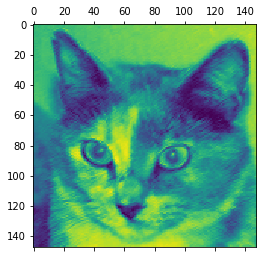

In [15]:
import matplotlib.pyplot as plt

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

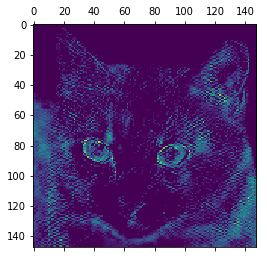

In [62]:
# посмотрим более глубокие каналы

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 31], cmap='viridis')
plt.show()

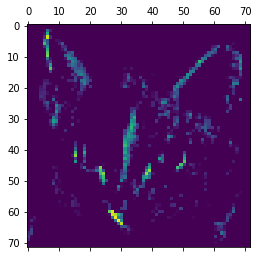

In [63]:
first_layer_activation = activations[2]
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

По сути видим, нахождение контуров именно кота. Чтож, давайте посмотрим на все визуализации сразу, на все наши выходные активации.

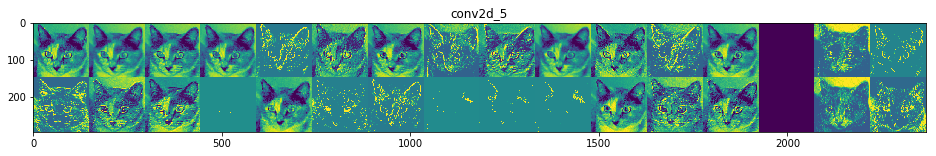

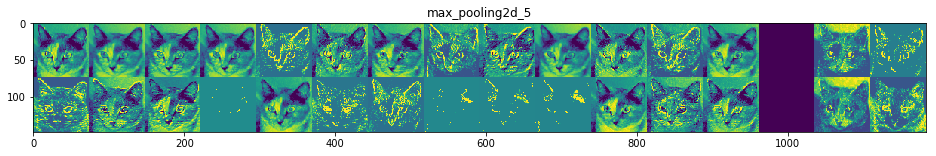

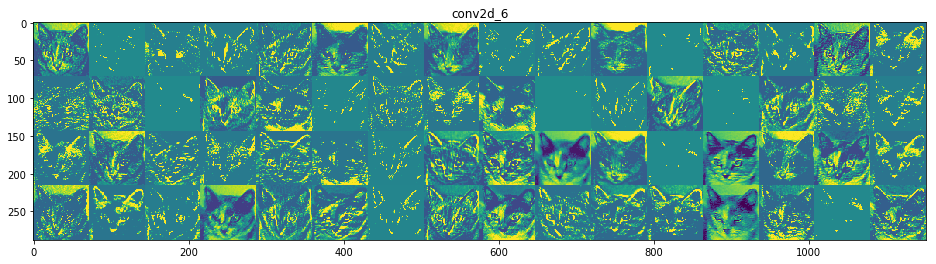

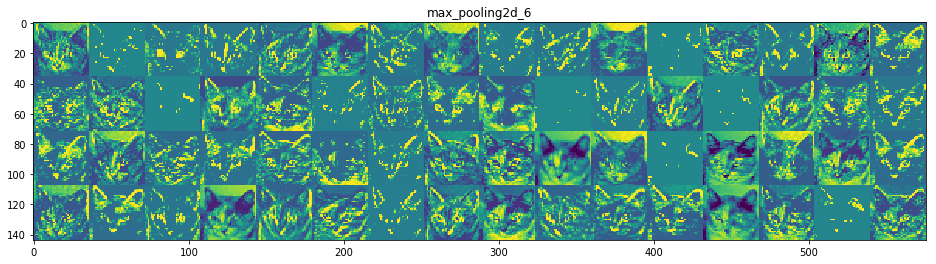

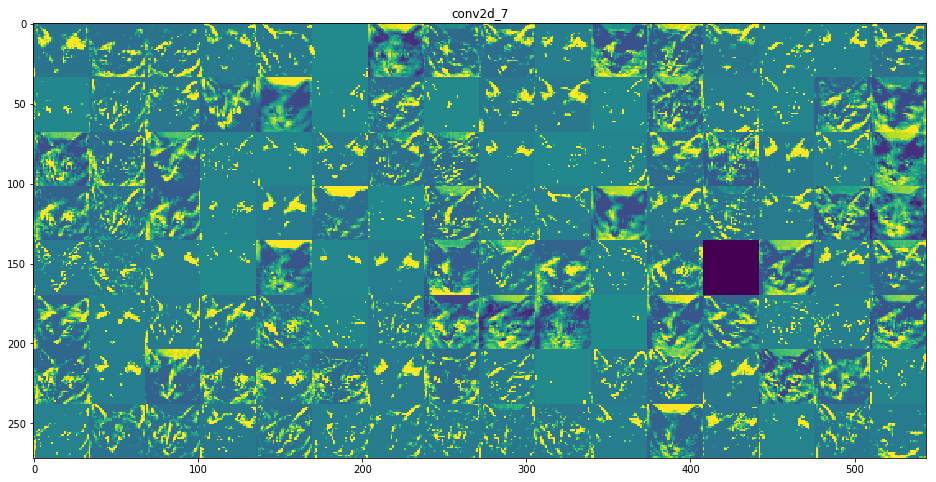

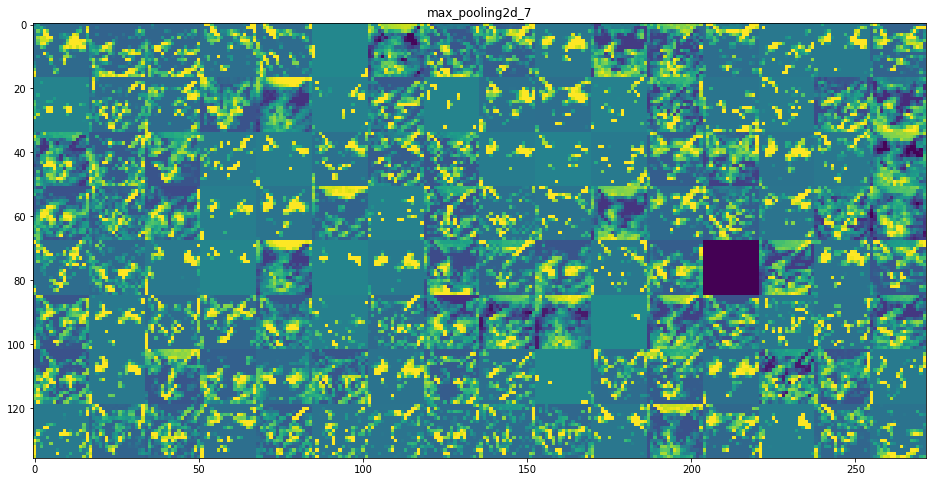

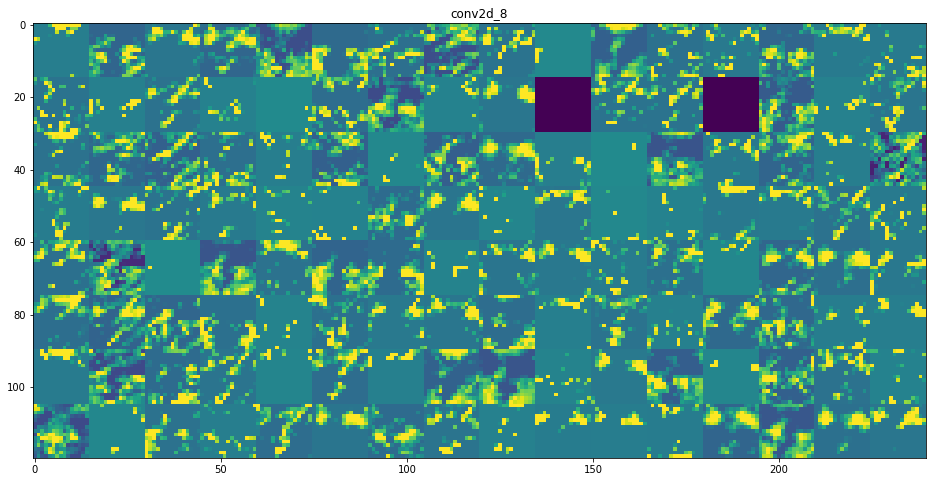

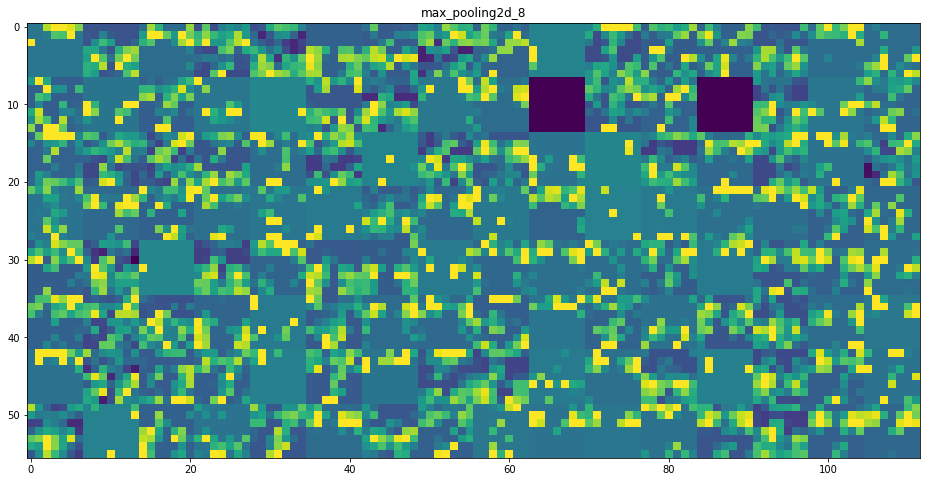

In [45]:
import keras


layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# функция для отображения всего и вся
for layer_name, layer_activation in zip(layer_names, activations):
    # тут у нас количество фичей входящих сетку
    n_features = layer_activation.shape[-1]

    # Карта признаков имеет следующую разнмерность (1, size, size, n_features)
    size = layer_activation.shape[1]

    
    # Переводим активационные каналы в матрицу
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Вывод каждого в большую горизонтальную сеть
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Обработка картинки, для приемлемой визуализации
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Отображаем полученную сетку из картинок
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Несколько итоговых закономерностей:

* Первый слой действует как коллекция разных детекторов контуров. На этом этапе активация сохраняет почти всю информацию, имеющуюся в исходном изображении
* по мере подъема вверх по слоям, активации становятся все более абстрактными, а их визуальная интерпретация все более сложной. Они начинают кодировать выскоуровневые понятия, такие как "кошачье уход" или "кошачьей глаз". Высокоуровневые представления несут все меньше информации об исходном изображении и все больше-о классе.
* Разреженность активаций растет с глубиной слоя. Все больше фильтров остается пустыми, что значит, что нет маски, попадающий в сеть. В нашем примере это не совсем так. 

Мы только что показали очень важную универсальную характеристику представлений, изучаемых глубокими нейронными сетями: особенности, извлеченные слоем, становятся все более абстрактными с глубиной слоя. Активация верхних слоев несет все меньше и меньше информации о конкретном изображении, и все больше и больше информации о цели (в нашем случае, класс изображения: кошка или собака). Глубокая нейронная сеть эффективно действует как конвейер перегонки информации, в котором исходные данные поступают (в нашем случае, изображения RBG) и многократно преобразуются, так что ненужная информация отфильтровывается (например, конкретный визуальный вид изображения), а полезная информация увеличивается и уточняется (например, класс изображения).

Это аналогично тому, как люди и животные воспринимают мир: наблюдая за сценой в течение нескольких секунд, человек может вспомнить, какие абстрактные объекты присутствовали в ней (например, велосипед, дерево), но не может вспомнить конкретный внешний вид этих объектов. На самом деле, если вы попытаетесь нарисовать универсальный велосипед прямо сейчас, скорее всего, вы не сможете получить его даже отдаленно правильно, даже если вы видели тысячи велосипедов в своей жизни. Попробуйте прямо сейчас: этот эффект абсолютно реален. Ваш мозг научился полностью абстрагировать свой визуальный ввод, трансформировать его в визуальные концепции высокого уровня, полностью отфильтровывая ненужные визуальные детали, что чрезвычайно затрудняет запоминание того, как на самом деле выглядят окружающие нас вещи.

## Визуализация фильров сверточных сетей


Другой простой способ исследовать фильтры, полученной сетью, - отобразить визуальный шаблон, за который отвечает каждый фильтр. Это можно сделать следюущим методом-методом градиентного восхождения в пространство входов (__gradient ascent in input space__). Выполняем градиентный спуск до значенния входного изображения сверточной нейронной сети, максимизируя отлик конкретного фильтра, начав с пустого изображения. В результате получаем версию входного изображения, для которого отклик данного фильтра был максимален.

Задача решается просто-конструируем функцию потерь, которая максимизирует значение данного фильтра данного сверточного слоя и обучаемся. Для пробы-возьмем VGG16 обученный на Imagenet.


In [14]:
!pip install keras

In [12]:
from keras.applications import VGG16
from keras import backend as K


K.clear_session()


model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

58892288/58889256 [==============================] - 24s 0us/step


Для реализации нам нужен градиент потерь относительно входа модели. Для этого возьмем метод 
`gradients` из Keras.

In [13]:
grads = K.gradients(loss, model.input)[0]

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

Иногда можно использовать неочевидный трюк, для ускорения схождения. Делим тензор на его L2 норму, это гарантирует, что величина обновлений всегда будет находится в одном диапозоне

In [21]:
# Добавим 1e-5 до деления, чтобы не делить на 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

Так, теперь нам надо посчитать определенные значения градиента, для каждого из тензоров. Используем `iterate` из Keras.

In [22]:
iterate = K.function([model.input], [loss, grads])

# Проверим
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

Наш ручной стохастический градиентный спуск готов!

In [23]:
# Начнем с серой картинки с черно-белым шумом.
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Обучаемся на 40 шагах
step = 1.  # Счетчик
for i in range(40):
    # Считаем лосс и градиент
    loss_value, grads_value = iterate([input_img_data])
    # Ходим в сторону максимизации потерь
    input_img_data += grads_value * step

Получили тензор`(1, 150, 150, 3)`, внутри которого совсем не лежат целые числа от `[0, 
255]`(как мы помним, именно так задаются картинки). Чтож, вернем все как было!

In [24]:
def deprocess_image(x):
   
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Мы молодцы, все сложили в функции. Чтож - сделаем все совсем красиво, обернем все сразу в функцию, которая принимает на вход имя слоя и индекс фильтра, а возвращает активацию данного фильтра.

In [25]:
def generate_pattern(layer_name, filter_index, size=150):

    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(150):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

Иии смотрим!

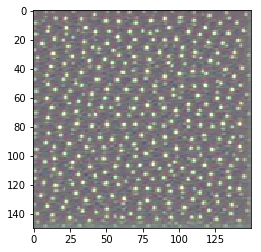

In [26]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

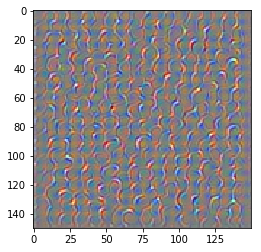

In [30]:
plt.imshow(generate_pattern('block3_conv2', 1))
plt.show()

Похоже данный фильр отвечает за узор в горошек. Чтож, посмотрим чуть более широко. Берем первые 64 фильра первых 4х блоков. Поехали!

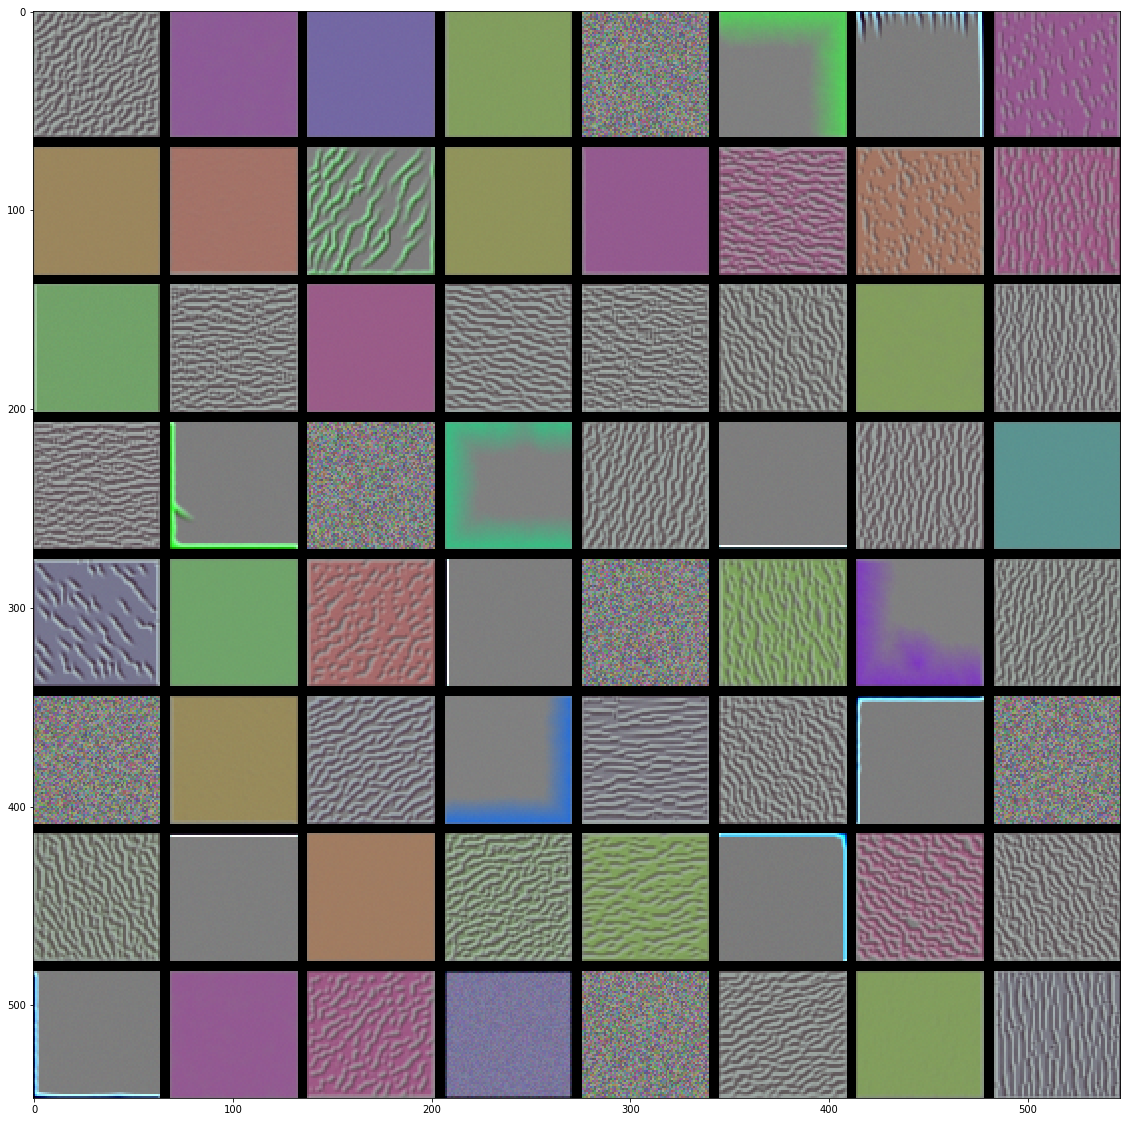

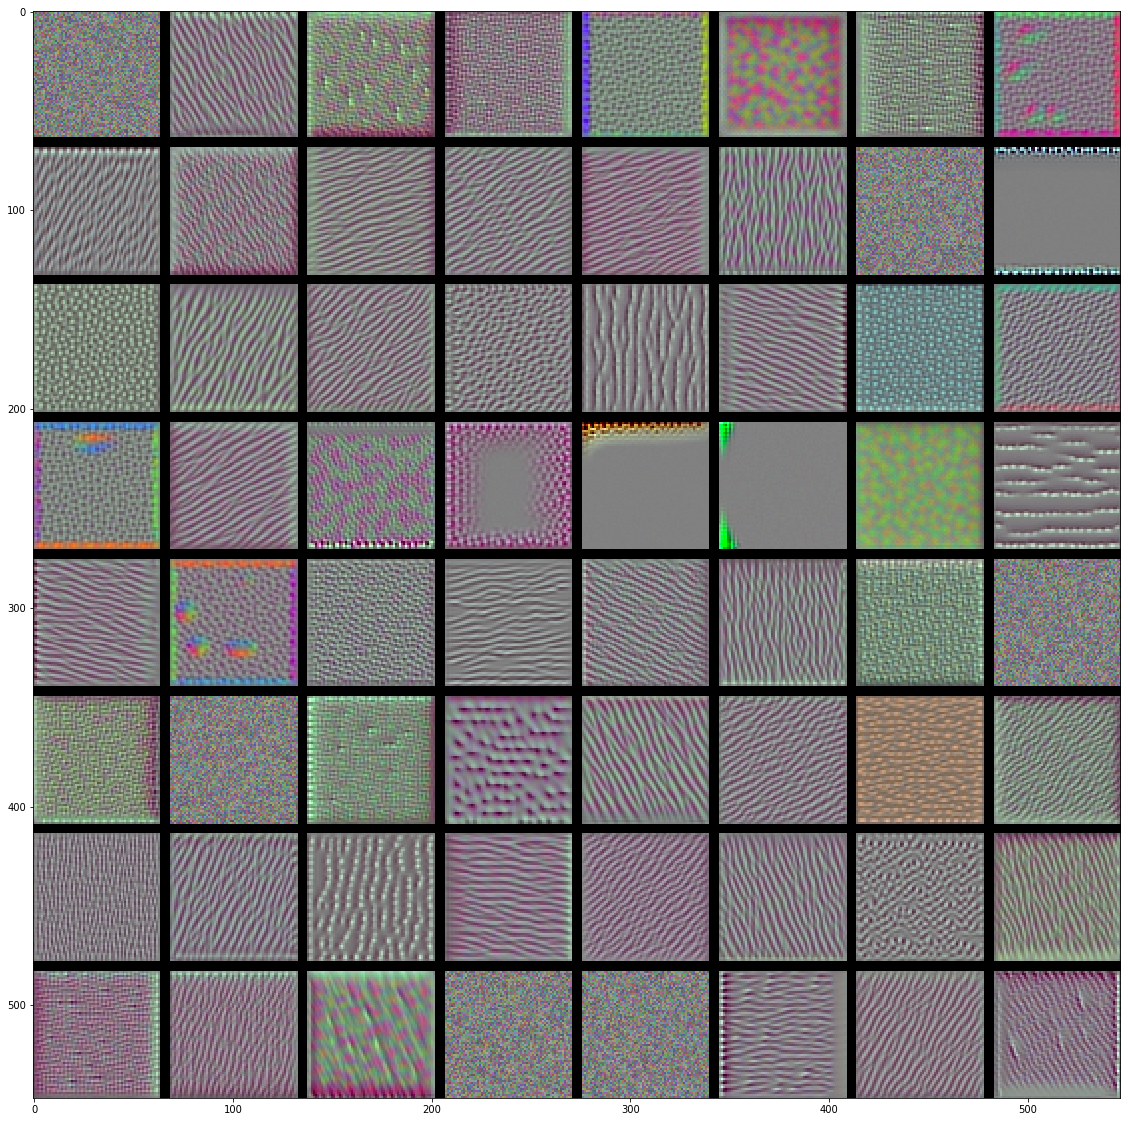

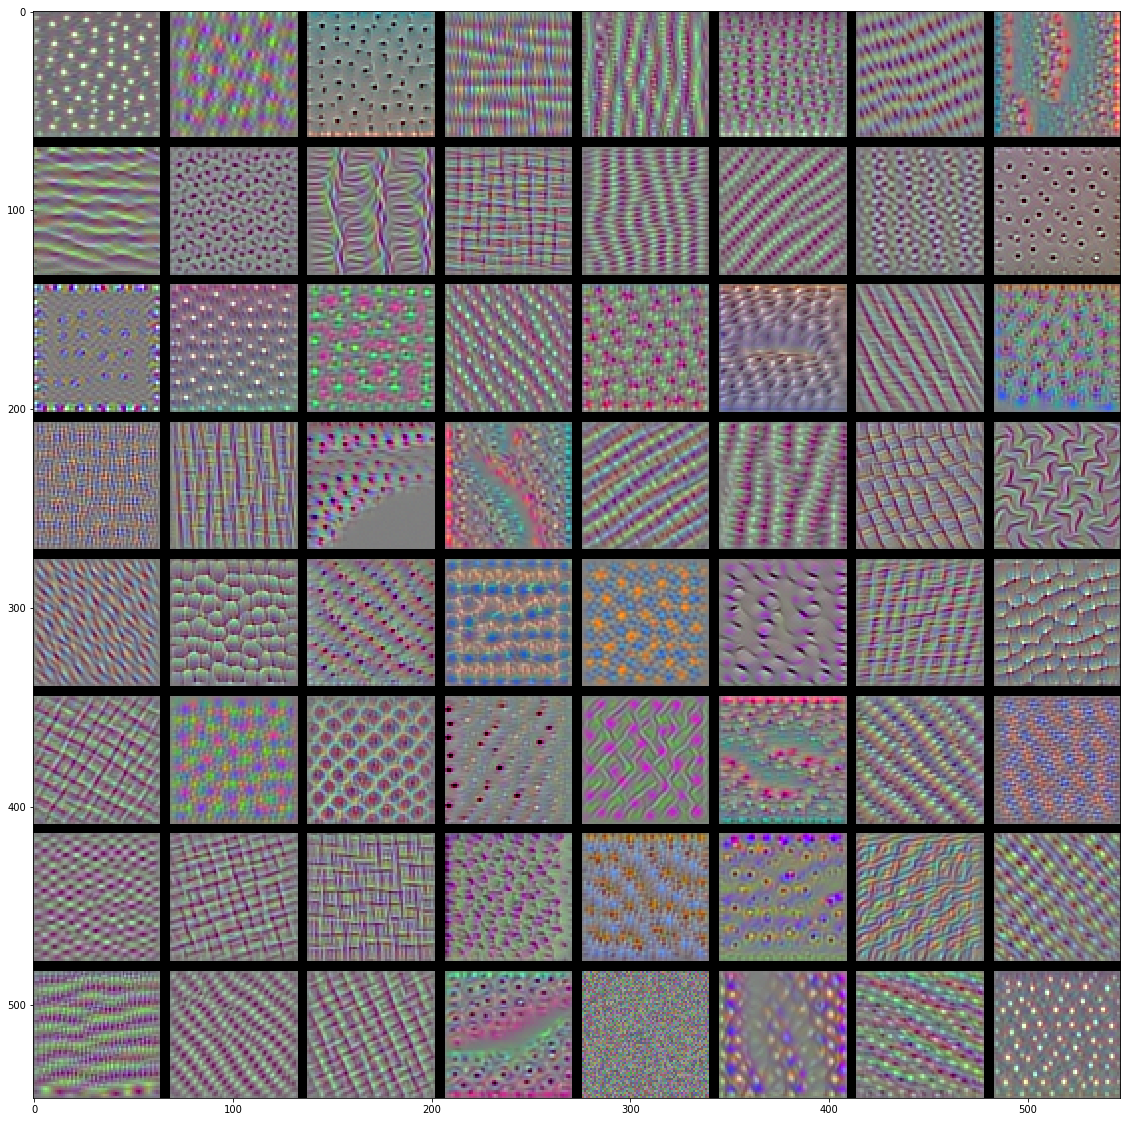

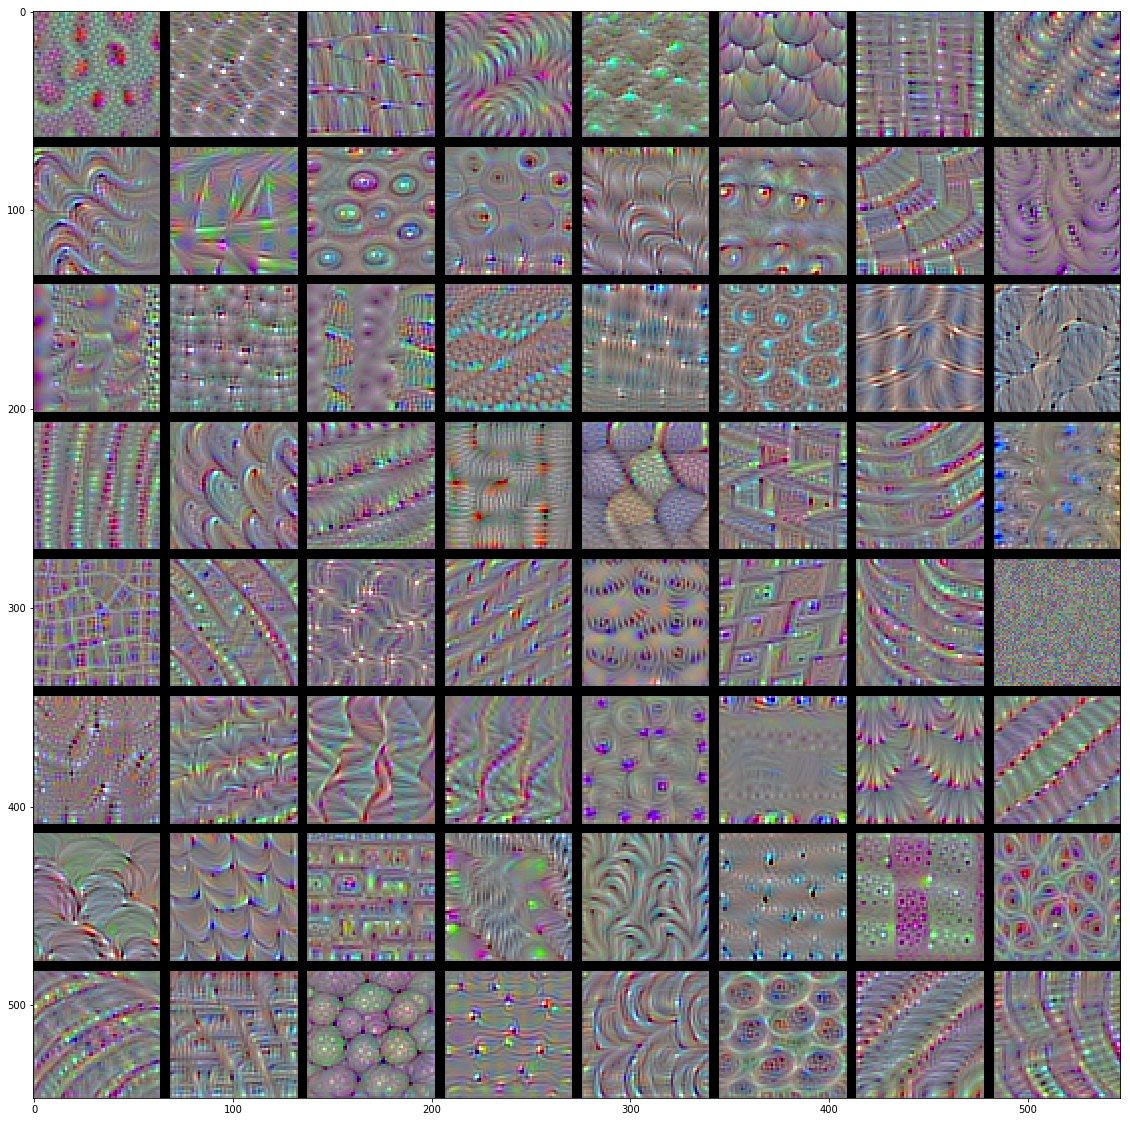

In [39]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # тут будем хранить результаты, пока же блок пустой
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # итерируемся по строкам нашего результаты
        for j in range(8):  # итерируемся по столбцам
            
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # кладем результаты в квадраты
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Визуализация результатов в сетке
    results=results.astype(int)
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

Такой подход помогает нам понять, как сетки видят мир. Похоже на разложение Фурье, когда мы рассладываем сигнал на частоты.


* Фильры из первого слоя в модели (`block1_conv1`) кодирует простые направления или цвета (или могут цветные контуры)
* Фильтры `block2_conv1` кодирует простые текстуры, состоящие из комбинации контуров и цветов.
* Фильтры следующего уровня начинают напоминать текстуры в естественном изображении-перья, глаза, листья и т.д.

## Visualizing heatmaps of class activation

Мы представим еще один метод визуализации, который полезен для понимания того, какие части данного изображения привели сверточную сеть к его 
окончательному решению. Это полезно для "отладки" процесса принятия решения сверточной сети, в частности, в случае классификации 
ошибкок. Он также позволяет находить определенные объекты в изображении.

Эта общая категория методов называется визуализацией "карта активации класса" (CAM) и состоит в создании тепловых карт "класса 
активация" над входными изображениями.
Тепловая карта "активация класса" представляет собой двумерную сетку оценок, связанных с определенным выходным классом, вычисляемую для 
любого места в любом входном изображении, показывающее, как важно каждое место в отношении рассматриваемого класса. Например, учитывая 
изображение подается в одну из наших сверточных сетей "кошка против собаки", визуализация карты активации класса позволяет нам генерировать тепловую карту для класса "кошка", 
которая показывает, что важно для различий между этими классами

Конкретная реализация, которую мы будем использовать, описана в [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via 
Gradient-based Localization](https://arxiv.org/abs/1610.02391). Она очень проста: отобразить карту признаков для входного изображения, полученного на выходе сверточного слоя, и взвесить каждый канал в ней по градиенту класса. Интуитивно, взвешиваем признаки по их "важности\интенсивности" для каждого класса.

Мы еще раз продемонстрируем эту технику, используя предварительно обученную сеть VGG16:


In [124]:
from keras.applications.vgg16 import VGG16
K.clear_session()
model = VGG16(weights='imagenet')

2 Африканских слона у нас тут. Мама и малыш.

![elephants](image/Elefant.png)

нужно перевести наше изображение в то, которое понимает модель (244*244).

In [125]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np


img_path = 'image/creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [126]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354575)]



Видим первые 3 класса ответов:

* Африканский слон (с 92.5% вероятностью)
* кабан-секач (с 7% вероятностью)
* Индийский слон (с 0.4% вероятностью)

Сеть распознала, что это африканский слон. Это 386 класс.

In [127]:
np.argmax(preds[0])

386

Для визуализации той части картинки, которая повлияла на принятие решение воспользуемся алгоритмом, который описывали ранее


In [128]:
# выходная карта с последнего слоя
african_elephant_output = model.output[:, 386]


last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# вектор размера 512, где каждый элемент опредлеяте интенсивность градиента для каждого канала
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# собираем и получаем только определеные величины, только к выходной карте признаков.
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# Изображения ввиде 2х Numpy матриц
# для нашего изображения 2х слонов.
pooled_grads_value, conv_layer_output_value = iterate([x])

# Взвешиваем каждый канал на их "важность".
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]


heatmap = np.mean(conv_layer_output_value, axis=-1)

Будем использовать heatmap с распределением от 0 до 1.

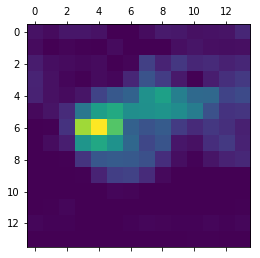

In [129]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Используем библиотечку opencv для наложения 2х картинок друг на друга.

In [130]:
import cv2


img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# конвертим в RGB
heatmap = np.uint8(255 * heatmap)

# накладываем
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('elephant_cam.jpg', superimposed_img)

True

![elephant cam](https://s3.amazonaws.com/book.keras.io/img/ch5/elephant_cam.jpg)

Такая визуализация помогает понять 2 важные вещи:

* Почему сеть решила, что на картинке изображен африканский слон?
* Где находится на картинке африканский слон?

Из интересного-уши слоненка оказались сильно активированы. Вероятно, именно так сеть отличает африканских слонов от индийских.
